In [1]:
# Connecting to clickhouse on remote server
import clickhouse_connect
clickhouse_client = clickhouse_connect.get_client(host='localhost')

import numpy as np
import pandas as pd

In [2]:
# query = """SELECT test_id, MAX(timestamp) as latest_timestamp
# FROM wgn
# GROUP BY test_id
# ORDER BY latest_timestamp;"""
# tests =  clickhouse_client.query(query)
# result_rows = tests.result_rows
# print(result_rows)
# test_ids = [row[0] for row in result_rows]
# test_ids = test_ids[:16]
# test_ids.remove('295eb4c9db974188a7879aa00dec1ee0')
# test_ids.remove('08ce66351a0247b19116962e0b01933c')
# print(test_ids)
# len(test_ids)

In [3]:


# df_dataset = pd.DataFrame()

# for test_id in test_ids:
#     print(f'------ Test ID {test_id}')
#     query = f"""
#         SELECT *
#         FROM wgn
#         WHERE test_id = '{test_id}' AND direction = 0
#         ORDER BY timestamp
#     """
#     df_wgn =  clickhouse_client.query_df(query)
#     # print(df_wgn)
#     # noise = df_wgn['noise_level'].to_numpy()
#     # print(noise)

#     # Group by noise_level and get the start (min) and stop (max) timestamps
#     df_noise_time_ranges = df_wgn.groupby('noise_level').agg(
#         begin_time=('timestamp', 'min'),
#         end_time=('timestamp', 'max'),
#         avg_throughput_mbps=('throughput_mbps', 'mean')
#     ).reset_index()
#     df_noise_time_ranges = df_noise_time_ranges.sort_values('noise_level')
#     # print(df_noise_time_ranges)

#     for index, noise_record in df_noise_time_ranges.iterrows():
#         query = f"""
#         SELECT * FROM MAC_KPIs_2 
#         WHERE TsTaiNs BETWEEN '{noise_record.begin_time}' AND '{noise_record.end_time}'
#         ORDER BY TsTaiNs DESC
#         """
#         # print(query)
#         df_mac_kpi = clickhouse_client.query_df(query)
#         # print(df_mac_kpi)
#         if noise_record.noise_level >= -8 and np.average(df_mac_kpi['ul_bler'].to_numpy()) < 0.8:
#             continue

#         new_rows = [{
#               'noise_level': noise_record.noise_level,
#               'throughput_mbps': noise_record.avg_throughput_mbps,
#               'phr': np.average(df_mac_kpi['phr'].to_numpy()),
#               'pusch_snr': np.average(df_mac_kpi['pusch_snr'].to_numpy()),
#               'ul_mcs': np.average(df_mac_kpi['ul_mcs1'].to_numpy()),
#               'ul_bler': np.average(df_mac_kpi['ul_bler'].to_numpy()),
#             },
#         ]
#         new_rows_df = pd.DataFrame(new_rows)
#         df_dataset = pd.concat([df_dataset, new_rows_df], ignore_index=True)
#     # break

# print(df_dataset)

# df_dataset.to_parquet("KPMs_Vs_Noise.parquet")

In [4]:
df_dataset = pd.read_parquet("KPMs_Vs_Noise.parquet")

In [5]:
grouped_df = df_dataset.groupby('noise_level')[['throughput_mbps', 'phr', 'pusch_snr', 'ul_mcs', 'ul_bler']].mean().reset_index()
grouped_df['throughput_mbps_normalized'] = grouped_df['throughput_mbps'] / grouped_df['throughput_mbps'].max()
grouped_df['pusch_snr_normalized'] = grouped_df['pusch_snr'] / grouped_df['pusch_snr'].max()
grouped_df['phr_normalized'] = 1 - grouped_df['phr'] / grouped_df['phr'].max()
grouped_df['pusch_snr_normalized'] = grouped_df['pusch_snr'] / grouped_df['pusch_snr'].max()
grouped_df['ul_mcs_normalized'] = grouped_df['ul_mcs'] / grouped_df['ul_mcs'].max()
grouped_df['ul_bler_normalized'] = grouped_df['ul_bler'] / grouped_df['ul_bler'].max()
print(grouped_df)

    noise_level  throughput_mbps        phr  pusch_snr     ul_mcs   ul_bler  \
0        -100.0        53.766954  59.587661  20.425364  17.011632  0.089957   
1         -90.0        53.794317  58.893004  20.656378  16.816872  0.090430   
2         -80.0        53.545433  59.916155  20.083845  16.789366  0.082613   
3         -70.0        53.862804  59.228106  20.606924  16.995927  0.094334   
4         -60.0        53.079516  60.572301  19.865580  16.674134  0.083743   
..          ...              ...        ...        ...        ...       ...   
75         -7.2         8.532640  43.666650   3.598954   6.098226  0.919171   
76         -7.0         8.582359  44.000508   3.269296   5.990233  0.906706   
77         -6.8        11.467314  39.734783   7.384783   5.984783  0.914008   
78         -6.6        11.711236  39.048017   7.534447   6.187891  0.881996   
79         -6.4        11.949839  40.033403   6.463466   6.179541  0.934081   

    throughput_mbps_normalized  pusch_snr_normalize

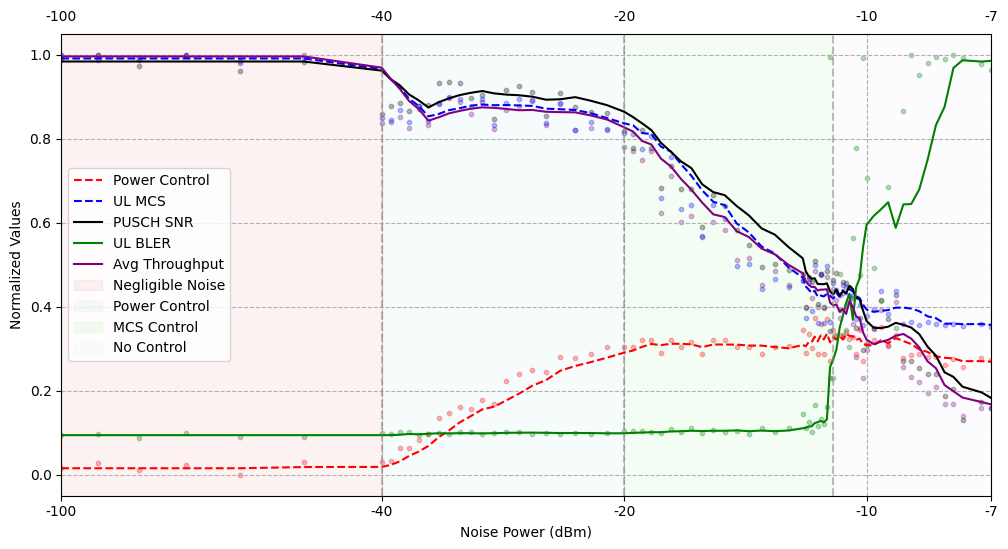

In [6]:
import matplotlib.pyplot as plt

window_size = 6
sorted_df = grouped_df.sort_values('noise_level')

# Compute moving averages (centered)
sorted_df['throughput_mbps_normalized_ma'] = sorted_df['throughput_mbps_normalized'].rolling(window=window_size, center=False).mean()
sorted_df['phr_normalized_ma'] = sorted_df['phr_normalized'].rolling(window=5, center=False).mean()
sorted_df['pusch_snr_normalized_ma'] = sorted_df['pusch_snr_normalized'].rolling(window=window_size, center=False).mean()
sorted_df['ul_mcs_normalized_ma'] = sorted_df['ul_mcs_normalized'].rolling(window=window_size, center=False).mean()
sorted_df['ul_bler_normalized_ma'] = sorted_df['ul_bler_normalized'].rolling(window=7, center=False).mean()

# Fill NaN values using ffill and bfill to avoid the FutureWarning
sorted_df['throughput_mbps_normalized_ma'] = sorted_df['throughput_mbps_normalized_ma'].ffill().bfill()
sorted_df['phr_normalized_ma'] = sorted_df['phr_normalized_ma'].ffill().bfill()
sorted_df['pusch_snr_normalized_ma'] = sorted_df['pusch_snr_normalized_ma'].ffill().bfill()
sorted_df['ul_mcs_normalized_ma'] = sorted_df['ul_mcs_normalized_ma'].ffill().bfill()
sorted_df['ul_bler_normalized_ma'] = sorted_df['ul_bler_normalized_ma'].ffill().bfill()

fig, ax = plt.subplots(figsize=(12, 6))

SCATTER_SIZE = 10
ALPHA = 0.3
ax.scatter(grouped_df['noise_level'], grouped_df['throughput_mbps_normalized'], color='purple', alpha=ALPHA, s=SCATTER_SIZE)
ax.scatter(grouped_df['noise_level'], grouped_df['phr_normalized'], color='red', alpha=ALPHA, s=SCATTER_SIZE)
ax.scatter(grouped_df['noise_level'], grouped_df['pusch_snr_normalized'], color='black', alpha=ALPHA, s=SCATTER_SIZE)
ax.scatter(grouped_df['noise_level'], grouped_df['ul_mcs_normalized'], color='blue', alpha=ALPHA, s=SCATTER_SIZE)
ax.scatter(grouped_df['noise_level'], grouped_df['ul_bler_normalized'], color='green', alpha=ALPHA, s=SCATTER_SIZE)

ax.plot(sorted_df['noise_level'], sorted_df['phr_normalized_ma'], color='red', linestyle='--', label='Power Control')
ax.plot(sorted_df['noise_level'], sorted_df['ul_mcs_normalized_ma'], color='blue', linestyle='--', label='UL MCS')
ax.plot(sorted_df['noise_level'], sorted_df['pusch_snr_normalized_ma'], color='black', linestyle='-', label='PUSCH SNR')
ax.plot(sorted_df['noise_level'], sorted_df['ul_bler_normalized_ma'], color='green', linestyle='-', label='UL BLER')
ax.plot(sorted_df['noise_level'], sorted_df['throughput_mbps_normalized_ma'], color='purple', linestyle='-', label='Avg Throughput')

K = 4
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lavender']  # Adjust for K regions
split_points = [-100, -40, -20, -11, -6]

ax.axvspan(split_points[0], split_points[1], color=colors[0], alpha=0.1, label=f'Negligible Noise')
ax.axvspan(split_points[1], split_points[2], color=colors[1], alpha=0.1, label=f'Power Control')
ax.axvspan(split_points[2], split_points[3], color=colors[2], alpha=0.1, label=f'MCS Control')
ax.axvspan(split_points[3], split_points[4], color=colors[3], alpha=0.1, label=f'No Control')

for split in split_points[1:-1]:
    ax.axvline(x=split, color='gray', linestyle='--', alpha=0.5)

plt.xlim(-100, -7)
plt.xlabel('Noise Power (dBm)')
plt.ylabel('Normalized Values')
# plt.title('PHR vs ')
plt.grid(True)

plt.xscale('symlog')
ax.set_xticks(np.arange(-100, -0, 10))
ticks = [-100, -40, -20, -10, -7]
plt.xticks(ticks)
plt.grid(True, which="both", ls="--")
ax.set_xticklabels(ticks, visible=True)

plt.legend()
plt.savefig("gNB_control_NoMbps.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()

In [7]:
test_ids = [
    '31f73544dae74716ba3af75330d02301',
    'b2a8430073e847cc86b19f940bd96f30',
    'de390cac8de345d997e8376a7e36eb5f',
    '71cbc372fc174c1ea07389b2d30bd4a7'
]

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# target_throughputs = [0, 4, 8, 128]
target_throughputs = [1, 4, 8, 16, 32, 64, 128]

In [9]:
# for target_throughput in target_throughputs:
#     df_dataset = pd.DataFrame()
#     for test_id in test_ids:
#         print(f'------ Test ID {test_id}')
#         query = f"""
#             SELECT *
#             FROM wgn
#             WHERE test_id = '{test_id}'
#             AND direction = 0
#             AND target_throughput_mbps = {target_throughput}
#             ORDER BY timestamp
#         """
#         df_wgn =  clickhouse_client.query_df(query)
#         # print(df_wgn)
#         # noise = df_wgn['noise_level'].to_numpy()
#         # print(noise)

#         query = f"""
#             SELECT *
#             FROM wgn
#             WHERE test_id = '{test_id}' AND direction = 0
#             ORDER BY timestamp
#         """
#         df_wgn_max_throughput =  clickhouse_client.query_df(query)
#         df_noise_time_ranges = df_wgn_max_throughput.groupby('noise_level').agg(
#             begin_time=('timestamp', 'min'),
#             end_time=('timestamp', 'max'),
#             avg_throughput_mbps=('throughput_mbps', 'max')
#         ).reset_index()
#         df_wgn_max_throughput = df_noise_time_ranges.sort_values('noise_level')
#         # print(df_wgn_max_throughput)
        
#         # Group by noise_level and get the start (min) and stop (max) timestamps
#         df_noise_time_ranges = df_wgn.groupby('noise_level').agg(
#             begin_time=('timestamp', 'min'),
#             end_time=('timestamp', 'max'),
#             # avg_throughput_mbps=('throughput_mbps', 'max')
#         ).reset_index()
#         df_noise_time_ranges = df_noise_time_ranges.sort_values('noise_level')
#         # print(df_noise_time_ranges)

#         df_noise_time_ranges['avg_throughput_mbps'] = df_wgn_max_throughput['avg_throughput_mbps']

#         for index, noise_record in df_noise_time_ranges.iterrows():
#             query = f"""
#             SELECT * FROM MAC_KPIs_2 
#             WHERE TsTaiNs BETWEEN '{noise_record.begin_time}' AND '{noise_record.end_time}'
#             ORDER BY TsTaiNs DESC
#             """
#             # print(query)
#             df_mac_kpi = clickhouse_client.query_df(query)
#             # print(df_mac_kpi)
#             if noise_record.noise_level >= -8.2 and np.average(df_mac_kpi['ul_bler'].to_numpy()) < 0.8:
#                 continue
    
#             new_rows = [{
#                   'noise_level': noise_record.noise_level,
#                   'throughput_mbps': noise_record.avg_throughput_mbps,
#                   'phr': np.average(df_mac_kpi['phr'].to_numpy()),
#                   'pusch_snr': np.average(df_mac_kpi['pusch_snr'].to_numpy()),
#                   'ul_mcs': np.average(df_mac_kpi['ul_mcs1'].to_numpy()),
#                   'ul_bler': np.average(df_mac_kpi['ul_bler'].to_numpy()),
#                 },
#             ]
#             new_rows_df = pd.DataFrame(new_rows)
#             df_dataset = pd.concat([df_dataset, new_rows_df], ignore_index=True)
#         # break
#     df_dataset.to_parquet(f"KPMs_Vs_Noise_target_throughput_{target_throughput}Mbps.parquet")

In [10]:
def plot_df(df):
    # print(df_dataset)
    grouped_df = df_dataset.groupby('noise_level')[['throughput_mbps', 'phr', 'pusch_snr', 'ul_mcs', 'ul_bler']].mean().reset_index()
    grouped_df['throughput_mbps_normalized'] = grouped_df['throughput_mbps'] / grouped_df['throughput_mbps'].max()
    grouped_df['pusch_snr_normalized'] = grouped_df['pusch_snr'] / grouped_df['pusch_snr'].max()
    grouped_df['phr_normalized'] = 1 - grouped_df['phr'] / grouped_df['phr'].max()
    grouped_df['pusch_snr_normalized'] = grouped_df['pusch_snr'] / grouped_df['pusch_snr'].max()
    grouped_df['ul_mcs_normalized'] = grouped_df['ul_mcs'] / grouped_df['ul_mcs'].max()
    grouped_df['ul_bler_normalized'] = grouped_df['ul_bler'] / grouped_df['ul_bler'].max()
    # print(grouped_df)


    window_size = 6
    sorted_df = grouped_df.sort_values('noise_level')
    
    # Compute moving averages (centered)
    sorted_df['throughput_mbps_normalized_ma'] = sorted_df['throughput_mbps_normalized'].rolling(window=window_size, center=False).mean()
    sorted_df['phr_normalized_ma'] = sorted_df['phr_normalized'].rolling(window=5, center=False).mean()
    sorted_df['pusch_snr_normalized_ma'] = sorted_df['pusch_snr_normalized'].rolling(window=window_size, center=False).mean()
    sorted_df['ul_mcs_normalized_ma'] = sorted_df['ul_mcs_normalized'].rolling(window=window_size, center=False).mean()
    sorted_df['ul_bler_normalized_ma'] = sorted_df['ul_bler_normalized'].rolling(window=7, center=False).mean()
    
    # Fill NaN values using ffill and bfill to avoid the FutureWarning
    sorted_df['throughput_mbps_normalized_ma'] = sorted_df['throughput_mbps_normalized_ma'].ffill().bfill()
    sorted_df['phr_normalized_ma'] = sorted_df['phr_normalized_ma'].ffill().bfill()
    sorted_df['pusch_snr_normalized_ma'] = sorted_df['pusch_snr_normalized_ma'].ffill().bfill()
    sorted_df['ul_mcs_normalized_ma'] = sorted_df['ul_mcs_normalized_ma'].ffill().bfill()
    sorted_df['ul_bler_normalized_ma'] = sorted_df['ul_bler_normalized_ma'].ffill().bfill()
        

    fig, ax = plt.subplots(figsize=(12, 4))
    

    K = 4
    colors = ['lightcoral', 'lightblue', 'lightgreen', 'lavender']  # Adjust for K regions
    if target_throughput == 0:
        split_points = [-100, -37, -18, -11.5, -6]
    if target_throughput == 1:
        split_points = [-100, -40, -21, -13.5, -6]
    elif target_throughput == 128:
        split_points = [-100, -40, -22, -11.2, -6]
    else:
        split_points = [-100, -40, -20, -10.2, -6]

    ax.axvspan(split_points[0], split_points[1], color=colors[0], alpha=0.2, label=f'Negligible Noise')
    ax.axvspan(split_points[1], split_points[2], color=colors[1], alpha=0.2, label=f'TPC')
    ax.axvspan(split_points[2], split_points[3], color=colors[2], alpha=0.2, label=f'MCS Control')
    ax.axvspan(split_points[3], split_points[4], color=colors[3], alpha=0.6, label=f'Out of Control')
    
    for split in split_points[1:-1]:
        ax.axvline(x=split, color='gray', linestyle='--', alpha=0.5)


    SCATTER_SIZE = 10
    ALPHA = 0.3
    ax.scatter(grouped_df['noise_level'], grouped_df['throughput_mbps_normalized'], color='purple', alpha=ALPHA, s=SCATTER_SIZE)
    ax.scatter(grouped_df['noise_level'], grouped_df['phr_normalized'], color='red', alpha=ALPHA, s=SCATTER_SIZE)
    ax.scatter(grouped_df['noise_level'], grouped_df['pusch_snr_normalized'], color='black', alpha=ALPHA, s=SCATTER_SIZE)
    ax.scatter(grouped_df['noise_level'], grouped_df['ul_mcs_normalized'], color='blue', alpha=ALPHA, s=SCATTER_SIZE)
    ax.scatter(grouped_df['noise_level'], grouped_df['ul_bler_normalized'], color='green', alpha=ALPHA, s=SCATTER_SIZE)

    LINE_WIDTH = 1.5
    ax.plot(sorted_df['noise_level'], sorted_df['phr_normalized_ma'], color='red', linestyle='--', linewidth=LINE_WIDTH, label='TPC')
    ax.plot(sorted_df['noise_level'], sorted_df['ul_mcs_normalized_ma'], color='blue', linestyle='--', linewidth=LINE_WIDTH, label='UL MCS')
    ax.plot(sorted_df['noise_level'], sorted_df['pusch_snr_normalized_ma'], color='black', linestyle='-', linewidth=LINE_WIDTH, label='PUSCH SNR')
    ax.plot(sorted_df['noise_level'], sorted_df['ul_bler_normalized_ma'], color='green', linestyle='-', linewidth=LINE_WIDTH, label='UL BLER')
    ax.plot(sorted_df['noise_level'], sorted_df['throughput_mbps_normalized_ma'], color='purple', linewidth=LINE_WIDTH, linestyle='-', label='Max Throughput')

    
    plt.xlim(-100, -8.2)
    plt.xlabel('Noise Power (dBm)')
    plt.ylabel('Normalized Values')
    # plt.title('PHR vs ')
    plt.grid(True)
    
    plt.xscale('symlog')
    ax.set_xticks(np.arange(-100, -0, 10))
    ticks = [-100, -40, -20, -10]
    plt.xticks(ticks)
    plt.grid(True, which="both", ls="--")
    ax.set_xticklabels(ticks, visible=True)

    plt.legend()
    plt.savefig(f"gNB_control_{target_throughput}Mbps.pdf", format="pdf", bbox_inches="tight")

    print(target_throughput)
    plt.show()
    plt.close()

1


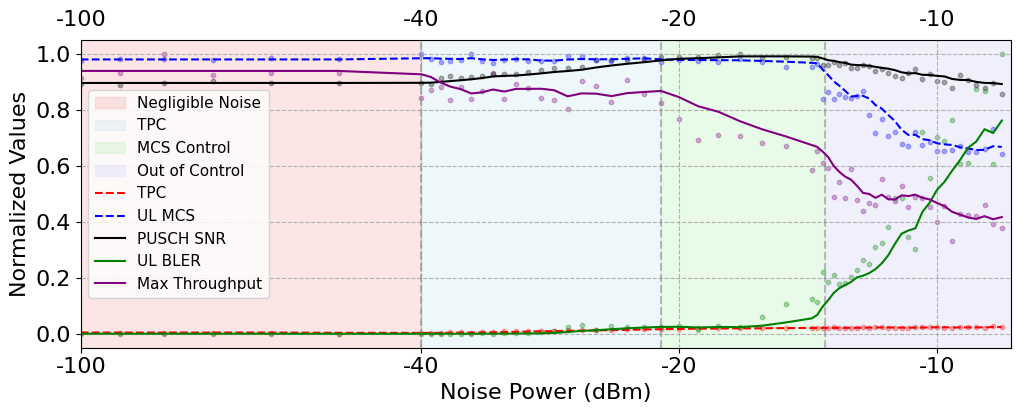

4


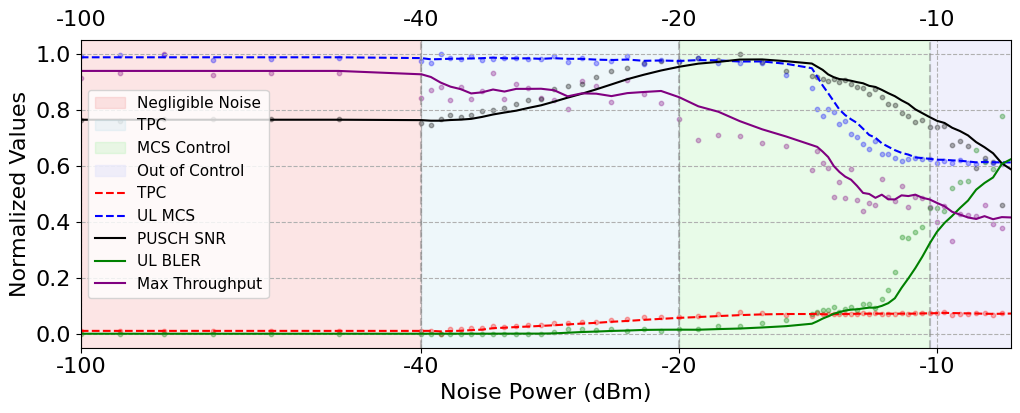

8


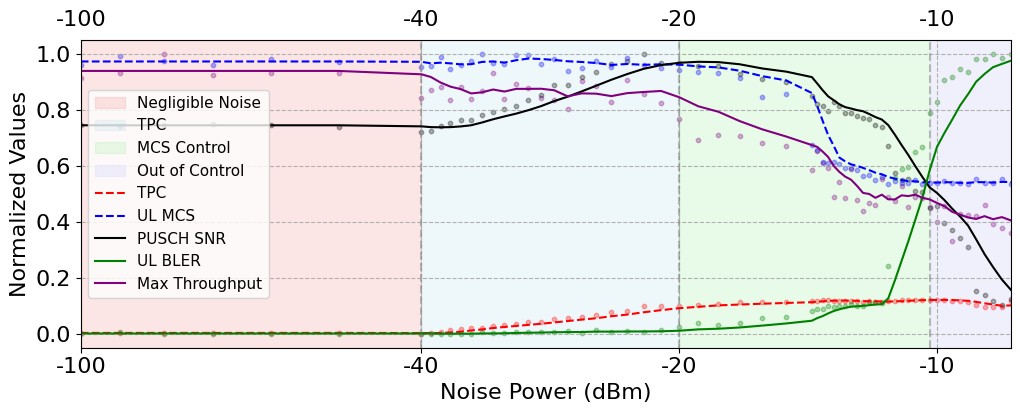

16


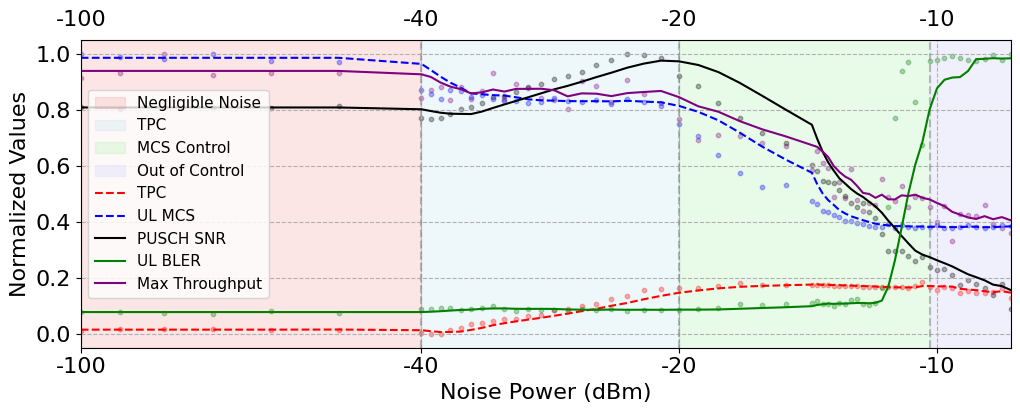

32


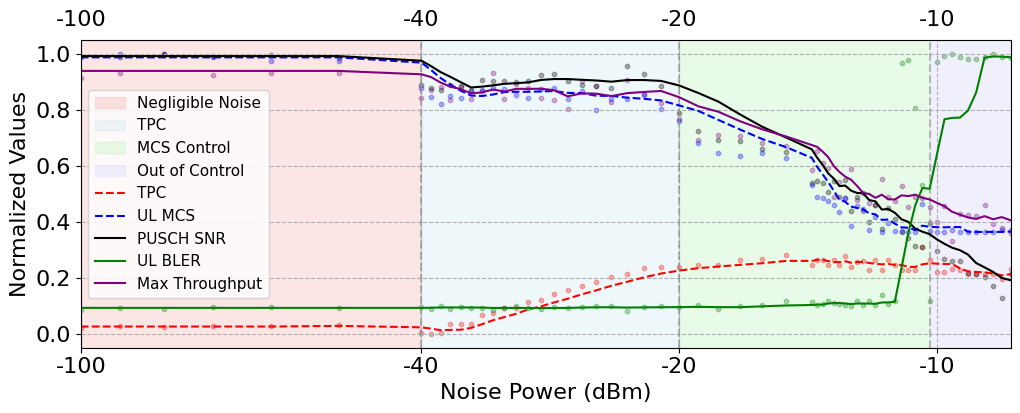

64


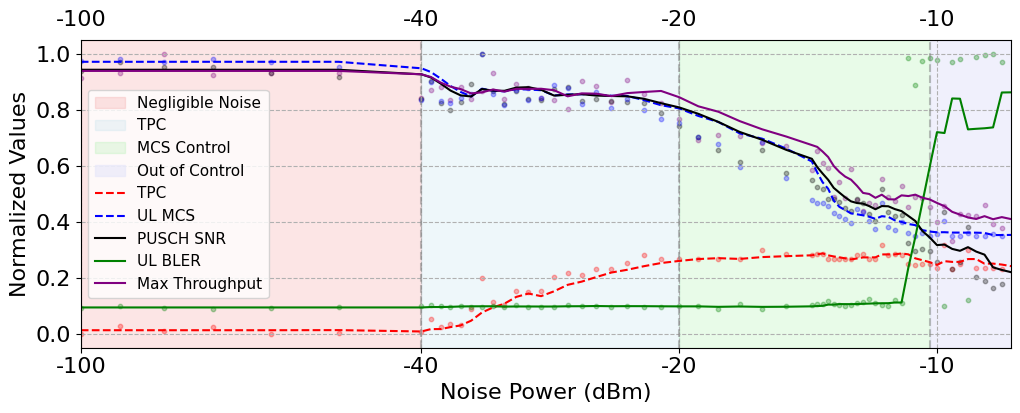

128


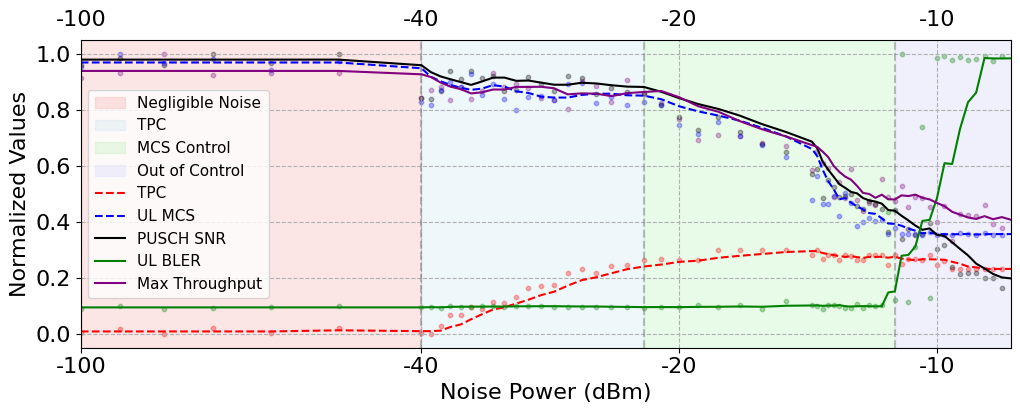

In [11]:
font_size = 16
plt.rcParams.update({
'font.size': font_size,              # General font size
'axes.titlesize': font_size,         # Title font size
'axes.labelsize': font_size,         # Axis label font size
'xtick.labelsize': font_size,        # X tick label font size
'ytick.labelsize': font_size,        # Y tick label font size
'legend.fontsize': font_size,        # Legend font size
})

plt.rcParams.update({
'legend.fontsize': 11,        # Legend font size
})

for target_throughput in target_throughputs:
    df_dataset = pd.read_parquet(f"KPMs_Vs_Noise_target_throughput_{target_throughput}Mbps.parquet")
    plot_df(df_dataset)

In [12]:
test_ids = [
    '31f73544dae74716ba3af75330d02301',
    'b2a8430073e847cc86b19f940bd96f30',
    'de390cac8de345d997e8376a7e36eb5f',
    '71cbc372fc174c1ea07389b2d30bd4a7'
]

------ Test ID 31f73544dae74716ba3af75330d02301
 - Noise level -60.0 between 2025-04-14 07:03:42 2025-04-14 07:04:11
fh


/tmp/ipykernel_81524/1683582940.py:61: RuntimeWarning: divide by zero encountered in log10
  axs.imshow(10*np.log10(np.abs(rx_slot**2)), aspect='auto')


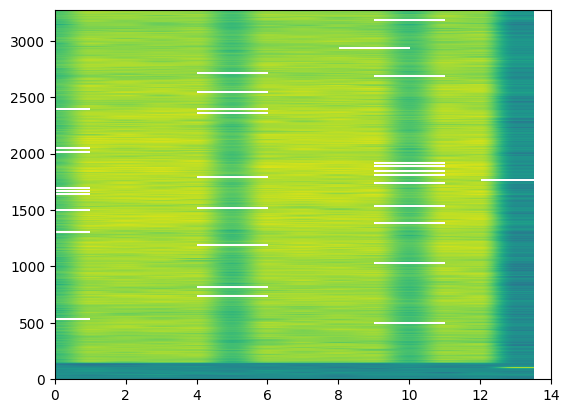

------ Test ID b2a8430073e847cc86b19f940bd96f30
 - Noise level -30.0 between 2025-04-14 08:45:57 2025-04-14 08:46:26
fh


/tmp/ipykernel_81524/1683582940.py:61: RuntimeWarning: divide by zero encountered in log10
  axs.imshow(10*np.log10(np.abs(rx_slot**2)), aspect='auto')


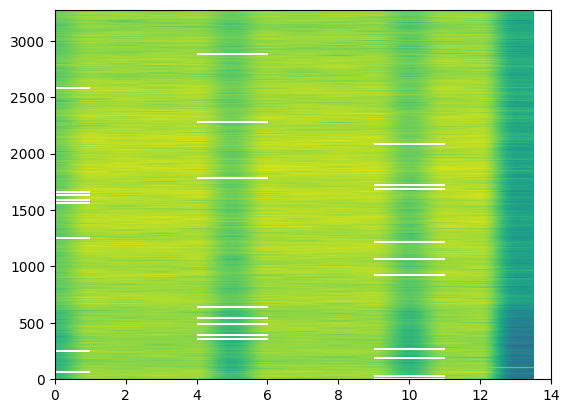

------ Test ID de390cac8de345d997e8376a7e36eb5f
 - Noise level -15.0 between 2025-04-14 10:46:16 2025-04-14 10:46:45
fh


/tmp/ipykernel_81524/1683582940.py:61: RuntimeWarning: divide by zero encountered in log10
  axs.imshow(10*np.log10(np.abs(rx_slot**2)), aspect='auto')


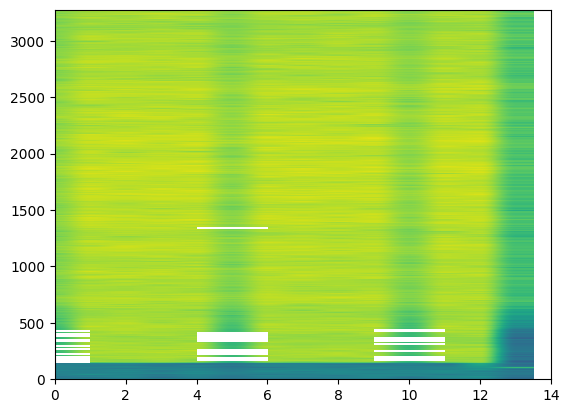

------ Test ID 71cbc372fc174c1ea07389b2d30bd4a7
 - Noise level -9.0 between 2025-04-14 14:13:57 2025-04-14 14:14:26
fh


/tmp/ipykernel_81524/1683582940.py:61: RuntimeWarning: divide by zero encountered in log10
  axs.imshow(10*np.log10(np.abs(rx_slot**2)), aspect='auto')


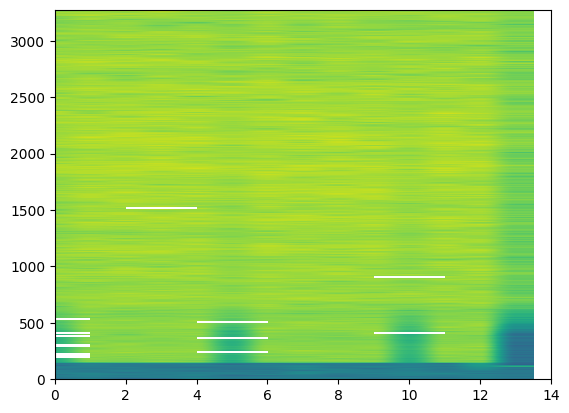

In [13]:
import numpy as np
import pandas as pd
import pickle
import datetime

dataset = []
noise_levels = [-60, -30, -15, -9]

for test_id_idx, test_id in enumerate(test_ids):    
    print(f'------ Test ID {test_id}')
    query = f"""
        SELECT *
        FROM wgn
        WHERE test_id = '{test_id}' AND direction = 0 AND target_throughput_mbps = 128
        ORDER BY timestamp
    """
    df_wgn =  clickhouse_client.query_df(query)
    # print(df_wgn)
    # noise = df_wgn['noise_level'].to_numpy()
    # print(noise)

    # Group by noise_level and get the start (min) and stop (max) timestamps
    df_noise_time_ranges = df_wgn.groupby('noise_level').agg(
        begin_time=('timestamp', 'min'),
        end_time=('timestamp', 'max'),
    ).reset_index()
    df_noise_time_ranges = df_noise_time_ranges.sort_values('noise_level')
    # print(df_noise_time_ranges)

    for index_i, noise_record in df_noise_time_ranges.iterrows():
        if noise_record.noise_level not in noise_levels:
            continue
        print(f" - Noise level {noise_record.noise_level} between {noise_record.begin_time} {noise_record.end_time}")
        
        print("fh")
        # Build the query
        query = f"""
        SELECT TsTaiNs,fhData
        FROM fh
        WHERE TsTaiNs BETWEEN '{noise_record.begin_time + datetime.timedelta(seconds=4)}' AND '{noise_record.begin_time + datetime.timedelta(seconds=5)}'
        ORDER BY TsTaiNs DESC
        LIMIT 1
        """
        # print(query)
        df_fh = clickhouse_client.query_df(query)
        # print(df_fh)

        fh_samp = np.array(df_fh['fhData'].iloc[0], dtype=np.float32)
        rx_slot = np.swapaxes(fh_samp.view(np.complex64).reshape(4, 14, 273*12), 2, 0)[:,:,0]

        font_size = 10
        plt.rcParams.update({
        'font.size': font_size,              # General font size
        'axes.titlesize': font_size,         # Title font size
        'axes.labelsize': font_size,         # Axis label font size
        'xtick.labelsize': font_size,        # X tick label font size
        'ytick.labelsize': font_size,        # Y tick label font size
        'legend.fontsize': font_size,        # Legend font size
        })
        fig, axs = plt.subplots(1)
        axs.imshow(10*np.log10(np.abs(rx_slot**2)), aspect='auto')
        axs.set_ylim([0, 273 * 12])
        axs.set_xlim([0, 14])
        # axs.set_title('Ant ' + str(0))
        # axs.set(xlabel='Symbol', ylabel='Resource Element')
        axs.label_outer()
        plt.savefig(f"spectrogram_highload_{noise_record.noise_level}dBm.pdf", format="pdf", bbox_inches="tight")
        # fig.suptitle('Power in RU Antennas') 
        plt.show(fig)
    #     break
    # break